## Online Assessment for Robinhood  

In [1]:
# Import packages
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime
from xgboost import XGBClassifier  
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score 
from matplotlib import pyplot

In [18]:
def column(matrix, i):
    return [row[i] for row in matrix]

### a. percentage of users have churned in the data  

In [2]:
# a
# percentage of users have churned in the data  
# churned = equity value < 10 for 28 calendar days or longer   

# account equity value per login
equity_value = pd.read_csv('equity_value_data.csv')

# The definition of Churned.
# The base of Churn rate is the cumulative accounts originated before the date.
# Condition 1: Since all accounts appeared in equity_value table,  
#              for the date that the accounts have not in equity_value 
#              more than 28 days.
# Condition 2: If any accounts return, then they are not churned.   
# Condition 3: The first date per account is its origination date. 

# Identify the orgination date per account
orgination_date = equity_value.groupby('user_id')['timestamp'].min()
orgination_date = pd.DataFrame(orgination_date )
orgination_date.reset_index(inplace=True)

# Double check the date information 
# From '2016-08-16T00:00:00Z' to '2017-08-18T00:00:00Z'
# 255 workdays
# Excluded 52 Saturdays
# Excluded 52 Sundays
# Excluded 8 holidays: 
#       Labor day 9/5/2016
#       Thanksgiving Day, 11/24/2016
#       Chirstmas Day, 12/26/2016
#       New Year's Day, 1/2/2017
#       Martin Luther King Day, 1/16/2017
#       Presidents' Day, 2/20/2017
#       Memorial Day, 5/29/2017
#       Independence Day, 7/4/2017
# Therefore, the date of unique dates in equity_value table is used 
date = sorted(list(equity_value.timestamp.unique()))
# Get all user_id
user_id = sorted(list(equity_value.user_id.unique()))

# Define the full dataset
all_data = []
for i in date:
    for k in user_id:
        all_data.append([i,k])
all_data = pd.DataFrame(all_data)
all_data.columns = ['timestamp','user_id']
all_data.sort_values(by=['user_id','timestamp'],inplace=True)
all_data = all_data.merge(equity_value,how='left',on=['user_id','timestamp'])

# Identify origination date, and consider accounts 
# treated as a user only after its first appearance
orgination_date.columns = ['user_id','timestamp_orig']
all_data = all_data.merge(orgination_date,how='left',on=['user_id'])
all_data = all_data[all_data['timestamp'] > all_data['timestamp_orig']]
all_data['churned'] = 0

# Search for churn per users over valid period
# churned = equity value < 10 for 28 CALENDAR days or longer   

temp_id, temp_last_active_date = '', ''
for index, row in all_data.iterrows():
    if row['user_id'] == temp_id:
        if row['close_equity'] >= 10:
            temp_last_active_date = datetime.strptime(row['timestamp'][:10], "%Y-%m-%d")
        else:            
            if abs((temp_last_active_date - datetime.strptime(row['timestamp'][:10], "%Y-%m-%d")).days) >= 28:
                all_data['churned'][index] = 1
    else:
        temp_id = row['user_id']
        # Since all accounts' first appearance treated as origination date
        temp_last_active_date = datetime.strptime(row['timestamp'][:10], "%Y-%m-%d")

<ipython-input-2-a8def295963c>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data['churned'][index] = 1


In [3]:
# The percentage of users have churned ever
all_data[all_data['churned'] == 1].user_id.nunique() / all_data.user_id.nunique()

0.17997851002865328

### b. Churn Rate modeling

In [4]:
# Q2 Modeling  

# features: The account origination info
features = pd.read_csv('features_data.csv')
# Churn probability per user
churned = all_data.groupby('user_id')['churned'].max()
churned = pd.DataFrame(churned)
churned.reset_index(inplace=True)
features = features.merge(churned,on='user_id')

# define origination related variables 
orgination_date['orig_year'] = orgination_date.apply(lambda x: int(x['timestamp_orig'][:4]), axis=1)
orgination_date['orig_year_2016'] = np.where(orgination_date['orig_year']==2016, 1, 0) 
orgination_date['orig_month'] = orgination_date.apply(lambda x: int(x['timestamp_orig'][5:7]), axis=1)
orgination_date['q1'] = np.where(orgination_date['orig_month']<=3, 1, 0) 
orgination_date['q2'] = np.where((orgination_date['orig_month']<=6) & (orgination_date['orig_month']>3), 1, 0) 
orgination_date['q3'] = np.where((orgination_date['orig_month']<=9) & (orgination_date['orig_month']>6), 1, 0) 
orgination_date['number_days_in_panel'] = orgination_date.apply(lambda x: abs(datetime.strptime('2017-08-18', "%Y-%m-%d") - datetime.strptime(x['timestamp_orig'][:10], "%Y-%m-%d")).days, axis=1)
features = features.merge(orgination_date,on='user_id')

In [5]:
# Categorical variable encoding
var_list = ['risk_tolerance','investment_experience',
            'platform','time_horizon','instrument_type_first_traded']
model_var = ['time_spent','first_deposit_amount','orig_year_2016','q1','q2','q3','number_days_in_panel']
for var in var_list:
    for i in list(features[var].unique())[:-1]:
        features[i] = np.where(features[var] == i, 1, 0)
        model_var.append(i)

##### Trial 1. XGBoost and variable importance

In [36]:
# See variable importance  

y = features['churned']
X = features[model_var]
xgb_model = XGBClassifier(silent=False, 
                          scale_pos_weight=1,
                          learning_rate=0.01,  
                          colsample_bytree = 0.4,
                          subsample = 0.8,
                          objective='binary:logistic', 
                          n_estimators=1000, 
                          reg_alpha = 0.3,
                          max_depth=6, 
                          gamma=10)
xgb_model.fit(X,y)
for i in range(len(xgb_model.feature_importances_)):
    print(model_var[i] + ': ' + str(xgb_model.feature_importances_[i]))

[19:34:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:34:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
time_spent: 0.038102537
first_deposit_amount: 0.057809275
orig_year_2016: 0.15209007
q1: 0.14242047
q2: 0.010727336
q3: 0.15855321
number_days_in_panel: 0.12695922
high_risk_tolerance: 0.048368327
med_risk_tolerance: 0.044029552
limited_investment_exp: 0.013033125
no_investment_exp: 0.015600157
good_inves

In [37]:
features['xgb_pred'] = column(xgb_model.predict_proba(X),1)
print('Predicted churn rate is ' + str(features['xgb_pred'].mean()))
print('Actual churn rate is ' + str(features['churned'].mean()))

Predicted churn rate is 0.1800125278278993
Actual churn rate is 0.17997851002865328


Notes here XGB is not adopted due to its performance.    


#####  Trial 2. Random Forest

In [25]:
# See variable importance  

y = features['churned']
X = features[model_var]
rf_model = RandomForestClassifier(max_depth=6)
rf_model.fit(X,y)
for i in range(len(rf_model.feature_importances_)):
    print(model_var[i] + ': ' + str(rf_model.feature_importances_[i]))

time_spent: 0.1155331005061021
first_deposit_amount: 0.16496721593675706
orig_year_2016: 0.06966901513985134
q1: 0.041483811539351205
q2: 0.0037906672969541854
q3: 0.10728889591426526
number_days_in_panel: 0.2923705785901366
high_risk_tolerance: 0.048441328752865935
med_risk_tolerance: 0.027641067543048202
limited_investment_exp: 0.009799273214871555
no_investment_exp: 0.013285352093156587
good_investment_exp: 0.009531975747709233
Android: 0.010970047318644099
iOS: 0.009549121290488601
med_time_horizon: 0.008739509398298729
short_time_horizon: 0.020094211973130785
stock: 0.009595948630306876
etp: 0.007694520584519845
adr: 0.006482885730289986
wrt: 0.004909443979587737
mlp: 0.0036663819508599765
0: 0.0008936806355881196
lp: 0.006029792590876294
rlt: 0.0014887988738894382
reit: 0.0039855189689074625
cef: 0.0020978557995428673


In [27]:
features['rf_pred'] = column(rf_model.predict_proba(X),1)
print('Predicted churn rate is ' + str(features['rf_pred'].mean()))
print('Actual churn rate is ' + str(features['churned'].mean()))

Predicted churn rate is 0.17984260015620981
Actual churn rate is 0.17997851002865328


#####  Trial 3. Logistic Model

- Lasso Logit regression is used for variable selection  
- Variance inflation factor is used to check multicolinearity  
- Variable selection:  
    - From the list of important features from the LASSO regression, perform the logit regression.
    - Backwards selection: Remove the least significant feature (largest p_value)
    - Check VIF, remove the multicolineared features

In [12]:
# Variable select with LASSO
lasso = LogisticRegression(C=0.05, penalty="l1", solver='liblinear')
l1_model = SelectFromModel(lasso.fit(X, y),prefit=True)

selected_feat = X.columns[(l1_model.get_support())]
print('total features: {}'.format((X.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('selected features: {}'.format(selected_feat.values))

total features: 26
selected features: 7
selected features: ['time_spent' 'first_deposit_amount' 'q3' 'number_days_in_panel'
 'high_risk_tolerance' 'short_time_horizon' 'stock']


In [13]:
# Logit model after variable selection
# Did backward selection manually
#X_logit = features[['time_spent', 'first_deposit_amount', 'number_days_in_panel',
#                    'high_risk_tolerance', 'short_time_horizon', 'stock' ]]
X_logit = features[['time_spent', 'first_deposit_amount', 'number_days_in_panel',
                    'high_risk_tolerance', 'short_time_horizon', 'stock']]
X_logit['intercept'] = 1
log_reg = sm.Logit(y, X_logit).fit() 
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.439150
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                churned   No. Observations:                 5584
Model:                          Logit   Df Residuals:                     5577
Method:                           MLE   Df Model:                            6
Date:                Mon, 14 Dec 2020   Pseudo R-squ.:                 0.06833
Time:                        19:28:26   Log-Likelihood:                -2452.2
converged:                       True   LL-Null:                       -2632.1
Covariance Type:            nonrobust   LLR p-value:                 1.259e-74
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
time_spent               0.0002      0.000      1.331      0.183      -0.000       0.001

<ipython-input-13-3132265560c4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_logit['intercept'] = 1


In [14]:
log_model = LogisticRegression().fit(X_logit,y)
features['logit_pred'] = column(log_model.predict_proba(X_logit),1)
print('Predicted churn rate is ' + str(features['logit_pred'].mean()))
print('Actual churn rate is ' + str(features['churned'].mean()))

Predicted churn rate is 0.17907848089935446
Actual churn rate is 0.17997851002865328


In [15]:
vif_data = pd.DataFrame() 
vif_data["feature"] = X_logit.columns[:-1] 

# Multicolinearity check
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X_logit.values, i) 
                          for i in range(len(X_logit.columns)-1)] 
vif_data

,feature,VIF
0,time_spent,1.005590
1,first_deposit_amount,1.006122
2,number_days_in_panel,1.021263
3,high_risk_tolerance,1.027647
4,short_time_horizon,1.019018
5,stock,1.004002


#####  AUC of ROC   

Randomly draw a sample from the modeling sample with replacement

In [16]:
val_sample_index = np.random.choice(range(len(features)),len(features),replace=True)
val_sample = features.iloc[list(val_sample_index)]

In [38]:
model_var = ['time_spent','first_deposit_amount','orig_year_2016','q1','q2','q3','number_days_in_panel']
for var in var_list:
    for i in list(features[var].unique())[:-1]:
        model_var.append(i)
val_sample['intercept'] = 1
xgb_pred_prob = xgb_model.predict_proba(val_sample[model_var])
rf_pred_prob  = rf_model.predict_proba(val_sample[model_var])
log_pred_prob = log_model.predict_proba(val_sample[X_logit.columns])

<ipython-input-38-145b0eb851f9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_sample['intercept'] = 1


In [39]:
log_auc = roc_auc_score(val_sample['churned'], column(log_pred_prob,1))
xgb_auc = roc_auc_score(val_sample['churned'], column(xgb_pred_prob,1))
rfm_auc = roc_auc_score(val_sample['churned'], column(rf_pred_prob,1))
print('Logistic: ROC AUC=%.3f' % (log_auc))
print('XGBoost: ROC AUC=%.3f' % (xgb_auc))
print('RF: ROC AUC=%.3f' % (rfm_auc))

Logistic: ROC AUC=0.711
XGBoost: ROC AUC=0.737
RF: ROC AUC=0.770


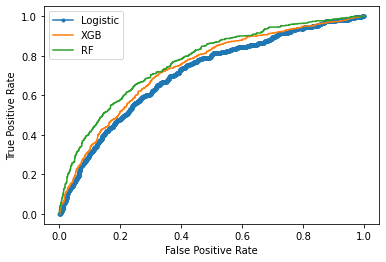

In [40]:
# calculate roc curves
log_fpr, log_tpr, _ = roc_curve(val_sample['churned'], column(log_pred_prob,1))
xgb_fpr, xgb_tpr, _ = roc_curve(val_sample['churned'], column(xgb_pred_prob,1))
rfm_fpr, rfm_tpr, _ = roc_curve(val_sample['churned'], column(rf_pred_prob,1))
# plot the roc curve for the model
pyplot.plot(log_fpr, log_tpr, marker='.', label='Logistic')
pyplot.plot(xgb_fpr, xgb_tpr,  label='XGB')
pyplot.plot(rfm_fpr, rfm_tpr,  label='RF')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

##### Conclusion.

Random Forest is preferred.     
XGBoost might have over-fitting issue with appropriate defined parameters.    
Logitistic regression needs to prevent multicolinearity and remove insignificant variables.  

### c. feature importance    

As shown above, I checked the feature importance with XG Boost, Random Forest and Lasso Regression, and found the most important variable (without the origination date related variables) based on **Random Forest** is 

- time_spent
- first_deposit_amount
- short_time_horizon
- iOS
- high_risk_tolerance
- med_time_horizon

In [41]:
# See variable importance  
var_list = ['risk_tolerance','investment_experience',
            'platform','time_horizon','instrument_type_first_traded']
model_var = ['time_spent','first_deposit_amount']
for var in var_list:
    for i in list(features[var].unique())[:-1]:
        features[i] = np.where(features[var] == i, 1, 0)
        model_var.append(i)             
             
y = features['churned']
X = features[model_var]
rf_model = RandomForestClassifier(max_depth=6)
rf_model.fit(X,y)
for i in range(len(rf_model.feature_importances_)):
    print(model_var[i] + ': ' + str(rf_model.feature_importances_[i]))

time_spent: 0.2681797672234218
first_deposit_amount: 0.33636188061175887
high_risk_tolerance: 0.10866087663558198
med_risk_tolerance: 0.05613427804975677
limited_investment_exp: 0.015324753368905993
no_investment_exp: 0.02215423242444683
good_investment_exp: 0.013369712234464034
Android: 0.016463300714870007
iOS: 0.014984789563322028
med_time_horizon: 0.019680526546607895
short_time_horizon: 0.03220790460979093
stock: 0.01750667015636346
etp: 0.013347596506420381
adr: 0.01029204342739363
wrt: 0.01276461483240701
mlp: 0.007453151301435698
0: 0.001787369020234052
lp: 0.01162350663403014
rlt: 0.006302736918936045
reit: 0.010887282206010658
cef: 0.004513007013841725


With the orgination date related variables (The date the per account first appeared)   

The most important variables are  
- time_spent
- number_days_in_panel
- first_deposit_amount
- -short_time_horizon
- iOS
- Android
- high_risk_tolerance
- q3

In [42]:
# See variable importance  
var_list = ['risk_tolerance','investment_experience',
            'platform','time_horizon','instrument_type_first_traded']
model_var = ['time_spent','first_deposit_amount','orig_year_2016','q1','q2','q3','number_days_in_panel']
for var in var_list:
    for i in list(features[var].unique())[:-1]:
        features[i] = np.where(features[var] == i, 1, 0)
        model_var.append(i)             
             
y = features['churned']
X = features[model_var]
rf_model = RandomForestClassifier(max_depth=6)
rf_model.fit(X,y)
for i in range(len(rf_model.feature_importances_)):
    print(model_var[i] + ': ' + str(rf_model.feature_importances_[i]))

time_spent: 0.11294630226624067
first_deposit_amount: 0.17013540737916105
orig_year_2016: 0.06183764097939575
q1: 0.048673940331912746
q2: 0.004643491259981527
q3: 0.1036465715046649
number_days_in_panel: 0.29733028091120806
high_risk_tolerance: 0.04890587228049329
med_risk_tolerance: 0.02711687210892111
limited_investment_exp: 0.01014495301287534
no_investment_exp: 0.013122916675491921
good_investment_exp: 0.009668765529286048
Android: 0.009889436203435164
iOS: 0.011307914188934265
med_time_horizon: 0.007894236541752288
short_time_horizon: 0.016769348856989972
stock: 0.007110205086508223
etp: 0.007807542018706118
adr: 0.006316155991235739
wrt: 0.003921454840765202
mlp: 0.003660634040127298
0: 0.0006455311860272779
lp: 0.007261179506517287
rlt: 0.002801446551362158
reit: 0.00480991724269292
cef: 0.001631983505313728
